In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv("credit_card_fraud.csv")

# Convert datetime columns
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])

# Create new features
df['trans_hour'] = df['trans_date_trans_time'].dt.hour
df['trans_day'] = df['trans_date_trans_time'].dt.day
df['trans_weekday'] = df['trans_date_trans_time'].dt.weekday

# Create age feature
df['age'] = df['trans_date_trans_time'].dt.year - df['dob'].dt.year

# Drop irrelevant columns
df.drop(['merchant', 'trans_num', 'job', 'dob', 'trans_date_trans_time'], axis=1, inplace=True)

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['category', 'state'], drop_first=True)

# Scale numerical features
scaler = StandardScaler()
numeric_cols = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'trans_hour', 'trans_day', 'trans_weekday', 'age']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Check result
df.head()


amt                      city       lat      long  city_pop  \
0  0.226702                    Orient  1.799586 -0.599770 -0.365123   
1  0.924893                Malad City  0.483186 -0.129583 -0.351456   
2  0.159035                   Grenada  0.371644 -0.940864 -0.363622   
3 -0.388483  High Rolls Mountain Park -1.330609  0.379699 -0.362564   
4 -0.394173                   Freedom  0.647348 -0.032138 -0.364024   

   merch_lat  merch_long  is_fraud  trans_hour  trans_day  ...  state_CO  \
0   1.839876   -0.597291         0    -1.88115  -1.673664  ...         0   
1   0.668861   -0.120981         0    -1.88115  -1.673664  ...         0   
2   0.377842   -0.916613         0    -1.88115  -1.673664  ...         0   
3  -1.336143    0.323925         0    -1.88115  -1.673664  ...         0   
4   0.786391   -0.065741         0    -1.88115  -1.673664  ...         0   

   state_HI  state_ID  state_MO  state_NE  state_NM  state_OR  state_UT  \
0         0         0         0         0         0         0         0   
1         0         1         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         1         0         0   
4         0         0         0         0         0         0         0   

   state_WA  state_WY  
0         1         0  
1         0         0  
2         0         0  
3         0         0  
4         0         1  

[5 rows x 37 columns]

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df['amt'], bins=50, kde=True)
plt.title('Distribution of Transaction Amount')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()


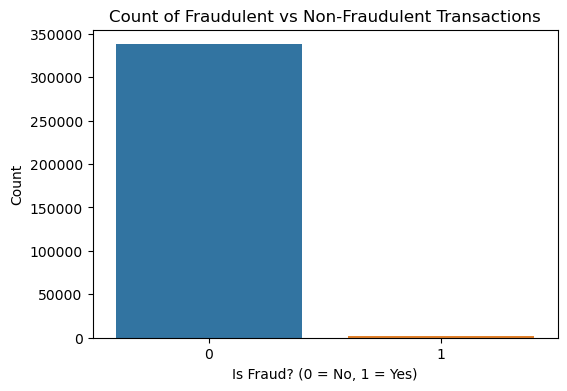

In [4]:
plt.figure(figsize=(6,4))
sns.countplot(x='is_fraud', data=df)
plt.title('Count of Fraudulent vs Non-Fraudulent Transactions')
plt.xlabel('Is Fraud? (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

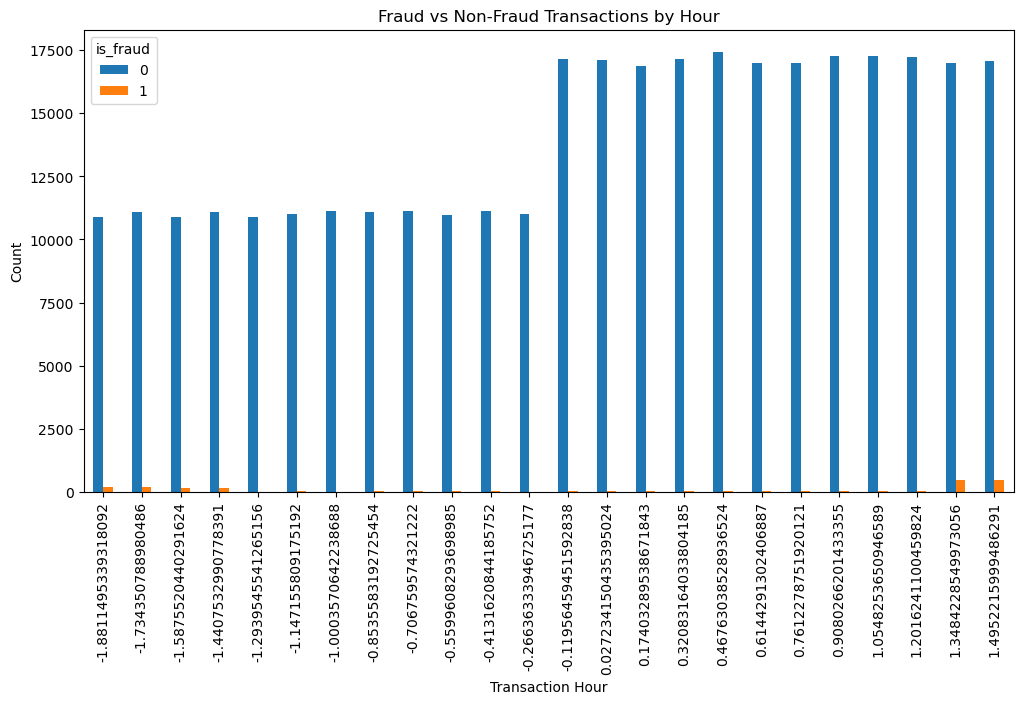

In [6]:
counts = df.groupby(['trans_hour', 'is_fraud']).size().unstack(fill_value=0)
counts.plot(kind='bar', stacked=False, figsize=(12,6))
plt.title('Fraud vs Non-Fraud Transactions by Hour')
plt.xlabel('Transaction Hour')
plt.ylabel('Count')
plt.show()

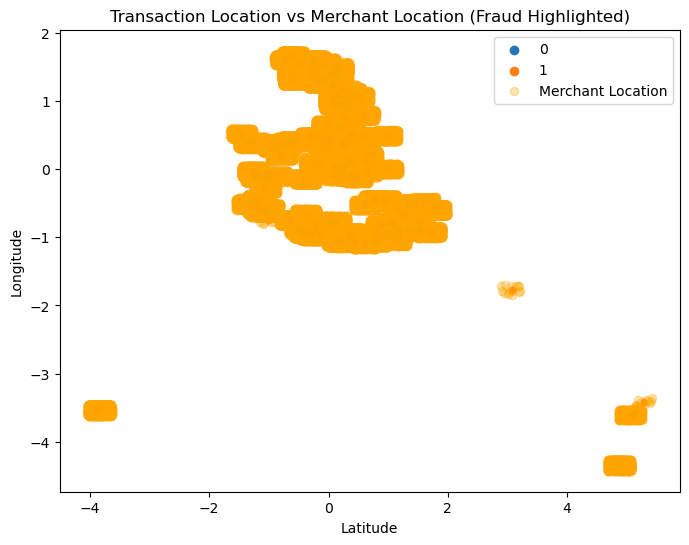

In [7]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='lat', y='long', hue='is_fraud', data=df, alpha=0.6)
plt.scatter(df['merch_lat'], df['merch_long'], color='orange', alpha=0.3, label='Merchant Location')
plt.title('Transaction Location vs Merchant Location (Fraud Highlighted)')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_8060\3116092197.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)


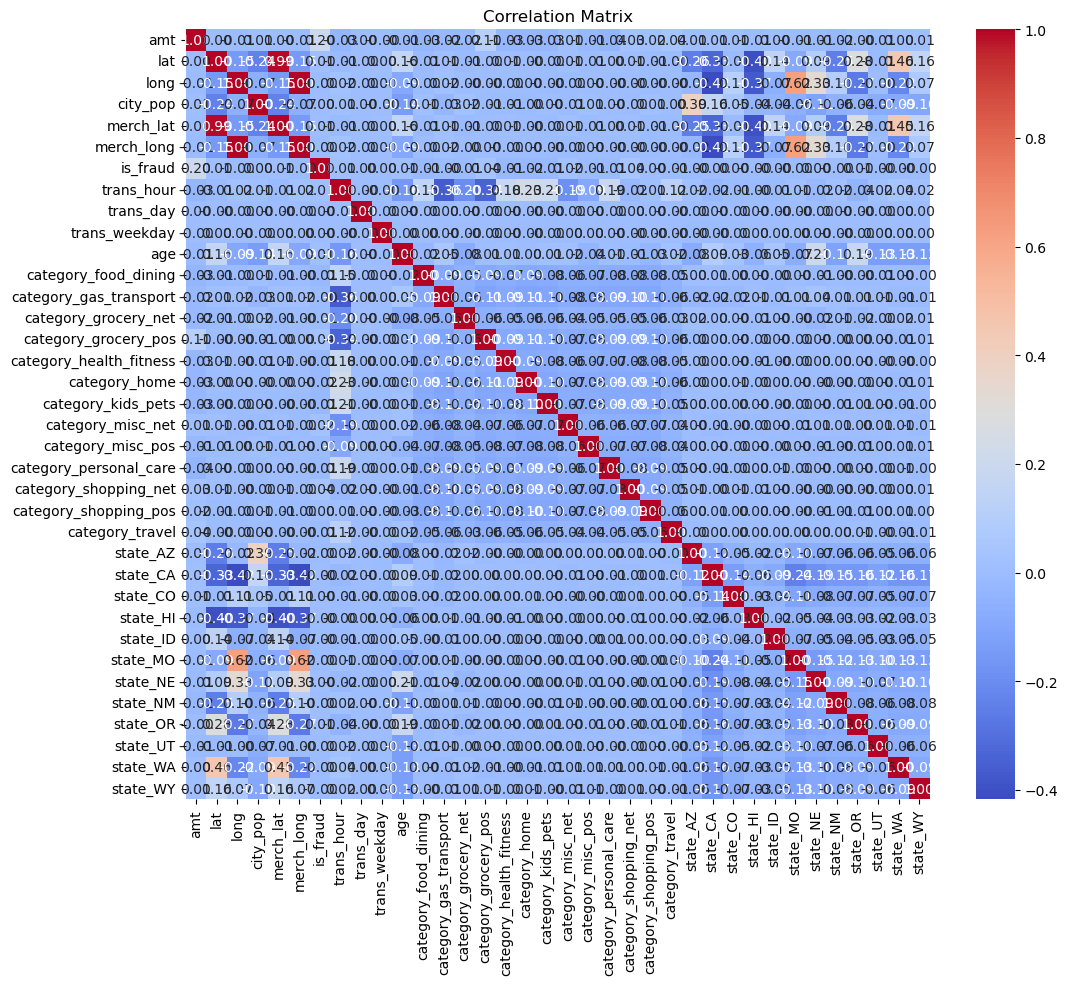

In [8]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

In [9]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Let's assume your features are all columns except 'is_fraud' and 'city' (categorical)
X = df.drop(['is_fraud', 'city'], axis=1)
y = df['is_fraud']

# Split data before applying SMOTE (important to avoid data leakage)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE on training data only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f'Before SMOTE, counts of label 1: {sum(y_train==1)}')
print(f'After SMOTE, counts of label 1: {sum(y_train_smote==1)}')

Before SMOTE, counts of label 1: 1426
After SMOTE, counts of label 1: 270259


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize models
logreg = LogisticRegression(max_iter=1000, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train Logistic Regression
logreg.fit(X_train_smote, y_train_smote)

# Train Random Forest
rf.fit(X_train_smote, y_train_smote)

# Predict on test data
y_pred_logreg = logreg.predict(X_test)
y_pred_rf = rf.predict(X_test)

# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg))

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     67566
           1       0.04      0.70      0.07       356

    accuracy                           0.91     67922
   macro avg       0.52      0.80      0.51     67922
weighted avg       0.99      0.91      0.95     67922

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     67566
           1       0.90      0.73      0.80       356

    accuracy                           1.00     67922
   macro avg       0.95      0.86      0.90     67922
weighted avg       1.00      1.00      1.00     67922

